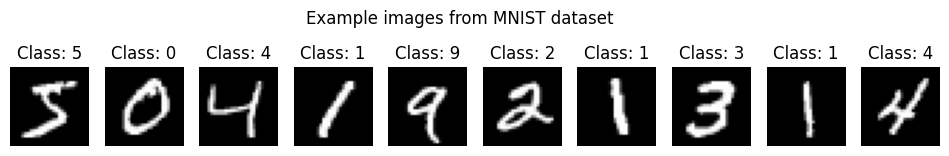

In [582]:
import torch
import numpy as np
from torchvision.transforms import v2, ToPILImage
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.v2.functional as F

transform = v2.Compose([v2.PILToTensor()])
# Load MNIST dataset
X_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
X_test = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Visualize some samples
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    input, classes = X_train[i]
    plt.imshow(input.squeeze(), cmap="gray")
    plt.title(f"Class: {classes}")
    plt.axis("off")

plt.suptitle("Example images from MNIST dataset")
plt.show()

## Very basic autoencoder

In [583]:

patch_size = 4
n_patches = 49
mask_ratio = 0.5
masked_img_size = 49- int(49 * mask_ratio)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

def extract_patches(img, patch_size):
    imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
    return imgp

def apply_mask(imgs, mask_ratio):
    batch_size = imgs.shape[0]
    num_patches = imgs.shape[1]
    mask_count = int(num_patches * mask_ratio)
    masks = torch.zeros(batch_size, num_patches)

    for i in range(batch_size):
        mask_idx = torch.randperm(num_patches)[:mask_count]
        masks[i, mask_idx] = 1  # Set the selected indices to 1 (mask)
    
    return masks

# Returns a tensor of size [batch_size, num_patches, patch_size, patch_size]
def collate_fn(batch):
    images, _ = zip(*batch)
    imgs = np.array([np.asarray(image) for image in images]) / 255.0
    imgs = torch.tensor(imgs, dtype=torch.float32)
    imgs_orig = imgs.clone().reshape(imgs.shape[0], -1)
    imgs = torch.cat([extract_patches(img, patch_size) for img in imgs], dim=1)
    imgs = imgs.permute(1, 0, 2, 3)
    return imgs, imgs_orig

batch_size = 256
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn, drop_last=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn, drop_last=True)


## Visualize

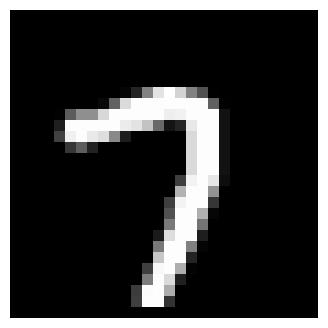

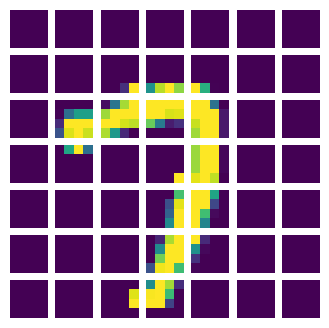

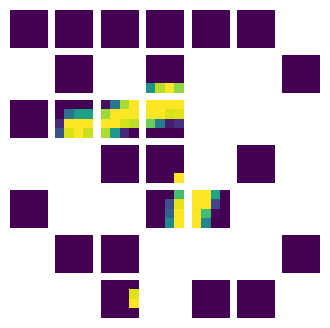

torch.Size([25, 4, 4])


In [584]:
imgs, imgs_orig = next(iter(train_loader))
img, imgs_orig = imgs[0], imgs_orig[0]
plt.figure(figsize=(4,4))
plt.imshow(imgs_orig.reshape(28,28), cmap="gray")
plt.axis("off")
plt.show()

fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(img):
    ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

masks = apply_mask(imgs, mask_ratio)

mask = masks[0]
fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(img):
    if mask[n] == 0:
        ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

print(img[mask.eq(0)].shape)  # Zero out the masked patches

In [585]:


class Autoencoder(nn.Module):
    def __init__(self, patch_size, masked_img_size):
        super(Autoencoder, self).__init__()
        self.patch_size = patch_size
        self.masked_img_size = masked_img_size
        self.patch_dim = masked_img_size*16*1  # Grayscale image, so 1 channel
        self.embed = 32
        self.embed_dim = masked_img_size*self.embed
        
        # Encoding layer
        self.enc_fc1 = nn.Linear(self.patch_dim, 256)
        self.enc_fc2 = nn.Linear(256, self.embed_dim)
        self.enc_act = nn.ReLU()
        
        self.enc_positions = nn.Parameter(torch.randn(masked_img_size, self.embed))  # +1 for cls_token

        # Decoding layer
        self.dec_fc1 = nn.Linear(49*32, 512)
        self.dec_fc2 = nn.Linear(512, 28*28)
        self.dec_act = nn.Sigmoid()

    def _initialize_weights(self):
        # Xavier initialization for Linear layers
        nn.init.xavier_uniform_(self.enc_fc.weight)
        nn.init.xavier_uniform_(self.dec_fc.weight)

    def encode(self, x):
        batch_s = x.shape[0]
        x = self.enc_fc1(x)
        x = self.enc_act(x)
        x = self.enc_fc2(x)
        x = self.enc_act(x)
        x = x.reshape(batch_s, self.masked_img_size, self.embed)
        # position = self.enc_positions.expand(batch_s, -1, -1)
        # x = x + position
        return x

    def decode(self, x, masks):
        batch_s = x.shape[0]

        # Initialize the token
        tokens = torch.zeros((batch_s, 49, 32))

        # Set the token in the unmasked positions as received from the encoder
        tokens[masks.eq(0)] = x.view(-1, 32)

        # Initialize a masked token
        num_masked = 49 - x.shape[1]
        mask_token = nn.Parameter(torch.zeros(batch_s, num_masked, 32)) # [1, 1, 32]
        torch.nn.init.normal_(mask_token, std=.02)

        # Set the values based on the mask token
        tokens[masks.eq(1)] = mask_token.expand(-1, num_masked, -1).view(-1, 32) # torch.Size([128, 49, 32])

        # Initialize the position
        # decoder_pos_embed = nn.Parameter(torch.zeros(batch_s, 49, 32))
        # tokens = tokens+decoder_pos_embed
                    
        tokens = tokens.view(batch_s, -1)
        # Feed to the decoder
        x = self.dec_fc1(tokens)
        x = self.enc_act(x)
        x = self.dec_fc2(x)
        x = self.dec_act(x)
        return x

    def forward(self, x):
        # Encoding and decoding patches
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded


In [586]:
# Initialize the model
model = Autoencoder(patch_size=patch_size, masked_img_size=masked_img_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.BCELoss()

# Training loop with patch masking
def train(model, train_loader, mask_ratio, patch_size):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        imgs, imgs_orig = batch
        imgs = imgs.to(device)
        imgs_orig = imgs_orig.to(device)

        batch_size, num_patches, h, w = imgs.shape
        imgs = imgs.view(batch_size, num_patches,  h * w)

        # Apply random mask
        masks = apply_mask(imgs, mask_ratio)
        
        img_data = imgs[masks.eq(0)].view(batch_size, masked_img_size * 16)

        # Forward pass with visible patches
        output = model.encode(img_data)
        output = model.decode(output, masks)
        # # Reconstruct and compute the loss with the original full image patches
        loss = loss_fn(output, imgs_orig)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss /= len(train_loader)
    return running_loss

# Training loop
epochs = 15
for epoch in range(epochs):
    train_loss = train(model, train_loader, mask_ratio, patch_size)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

100%|██████████| 234/234 [00:16<00:00, 14.07it/s]


Epoch 1/15, Loss: 0.2482


100%|██████████| 234/234 [00:16<00:00, 14.09it/s]


Epoch 2/15, Loss: 0.1615


100%|██████████| 234/234 [00:16<00:00, 13.90it/s]


Epoch 3/15, Loss: 0.1413


100%|██████████| 234/234 [00:16<00:00, 14.11it/s]


Epoch 4/15, Loss: 0.1338


100%|██████████| 234/234 [00:16<00:00, 14.03it/s]


Epoch 5/15, Loss: 0.1295


100%|██████████| 234/234 [00:16<00:00, 14.04it/s]


Epoch 6/15, Loss: 0.1271


100%|██████████| 234/234 [00:16<00:00, 14.01it/s]


Epoch 7/15, Loss: 0.1255


100%|██████████| 234/234 [00:16<00:00, 14.09it/s]


Epoch 8/15, Loss: 0.1242


100%|██████████| 234/234 [00:16<00:00, 13.97it/s]


Epoch 9/15, Loss: 0.1231


100%|██████████| 234/234 [00:16<00:00, 14.11it/s]


Epoch 10/15, Loss: 0.1222


100%|██████████| 234/234 [00:16<00:00, 14.16it/s]


Epoch 11/15, Loss: 0.1215


100%|██████████| 234/234 [00:16<00:00, 13.90it/s]


Epoch 12/15, Loss: 0.1208


100%|██████████| 234/234 [00:16<00:00, 14.13it/s]


Epoch 13/15, Loss: 0.1202


100%|██████████| 234/234 [00:16<00:00, 14.18it/s]


Epoch 14/15, Loss: 0.1198


100%|██████████| 234/234 [00:17<00:00, 13.47it/s]

Epoch 15/15, Loss: 0.1195


torch.Size([1, 400])
(1, 784)


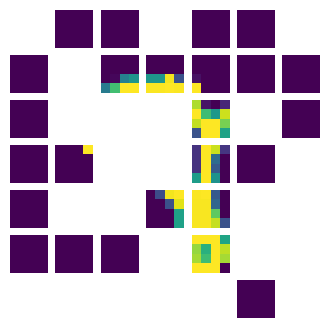

<function matplotlib.pyplot.show(close=None, block=None)>

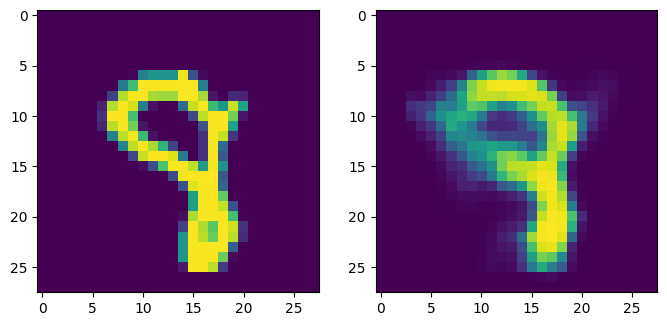

In [596]:
# Select a random sample
samples, orig = next(iter(test_loader))
masks = apply_mask(samples, mask_ratio)

img = samples[0]
orig = orig[0]
mask = masks[0]

# Use the encode and decode functions
masked = img.clone()[mask.eq(0)]
masked = masked.view(-1, masked_img_size*16)

print(masked.shape)
output = model.encode(masked)
output = model.decode(output, mask.unsqueeze(0)).detach().numpy()
print(output.shape)

fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(img):
    if mask[n] == 0:
        ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig.reshape(28,28))


plt.subplot(1,2,2)
plt.imshow(output.reshape(28,28))
plt.show




In [588]:

encoded = torch.zeros((128, 49, 16))
print(encoded.shape)
x = imgs.clone().reshape(128, 49, 16)
x2 = x[masks.eq(0)]
x3 = x[masks.eq(1)]

print(x2.shape)

encoded[masks.eq(0)] = x2
encoded[masks.eq(1)] = x3


torch.Size([128, 49, 16])


RuntimeError: shape '[128, 49, 16]' is invalid for input of size 200704

In [488]:

for batch in (train_loader):
    imgs, imgs_orig = batch
    imgs = imgs.to(device)
    imgs_orig = imgs_orig.to(device)

    batch_size, num_patches, h, w = imgs.shape
    imgs = imgs.view(batch_size, num_patches,  h * w)
    # print(batch.shape)

    masks = apply_mask(imgs, mask_ratio)
    img_data = imgs[masks.eq(0)].view(batch_size, masked_img_size * 16)

    break


In [487]:

masks = apply_mask(imgs, mask_ratio)
# Apply random mask
    


torch.Size([128, 25, 16])
